# `Fitty`: Fitting Theophylline pharmacokinetics

**Author: Raibatak Das**  
Last updated - **2024-SEP-13**

This Jupyter notebook is part of the documentation for the Julia package `Fitty` for nonlinear least squares regression. This notebook demonstrates how to use `Fitty` to estimate pharmacokinetic (PK) parameters of a drug from its serum concentration measured over time.

In [ ]:
using CSV, DataFrames, LaTeXStrings, PythonPlot, RDatasets, Statistics
using Pkg
Pkg.activate("..")
import Fitty

In [2]:
# # ONLY RELEVANT ON A MAC WITH RETINA DISPLAY

# # Run macro to produce high resolution plots
# # on a retina display
# @pyplot_retina
# # Update matplotlib settings
# mpl = PythonPlot.matplotlib
# mpl.rcParams["font.size"] = 14;
# mpl.rcParams["figure.dpi"] = 180;
# mpl.rcParams["axes.axisbelow"] = true;
# mpl.rcParams["axes.prop_cycle"] = mpl.cycler(color = mpl.colormaps["Dark2"].colors);

## 1. Load data

This example used the `theoph` dataset that reports the serum concentration of the anti-asthmatic drug theophylline in 12 subjects who were each given a single oral dose (Ref: https://stat.ethz.ch/R-manual/R-devel/library/datasets/html/Theoph.html)

In [3]:
theoph = dataset("datasets", "Theoph")

Row,Subject,Wt,Dose,Time,Conc
,Cat…,Float64,Float64,Float64,Float64
1,1,79.6,4.02,0.0,0.74
2,1,79.6,4.02,0.25,2.84
3,1,79.6,4.02,0.57,6.57
4,1,79.6,4.02,1.12,10.5
5,1,79.6,4.02,2.02,9.66
6,1,79.6,4.02,3.82,8.58
7,1,79.6,4.02,5.1,8.36
8,1,79.6,4.02,7.03,7.47
9,1,79.6,4.02,9.05,6.89


Plot PK profiles

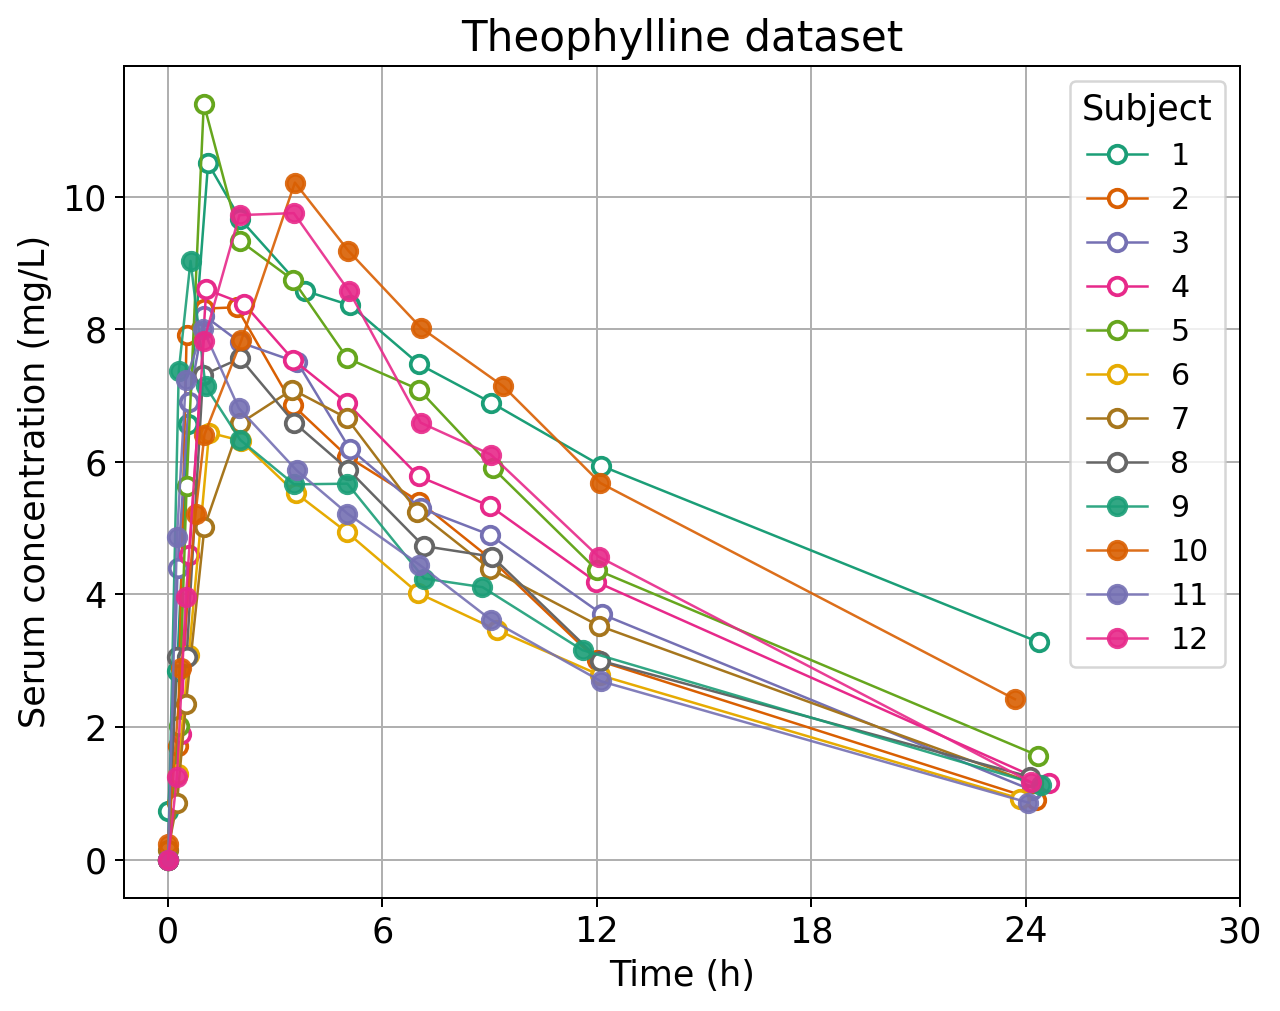

In [4]:
fig, ax = subplots(figsize = (8, 6))
for (s, df) in pairs(groupby(theoph, :Subject, sort = false))
    subj = s.Subject
    if subj in ["1", "2", "3", "4", "5", "6", "7", "8"]
        ax.plot(df.Time, df.Conc, "o-", ms = 7, mfc = "w", 
                mew = 1.5, lw = 1, label = subj)
    else
        ax.plot(df.Time, df.Conc, "o-", ms = 7, alpha = 0.9,
                mew = 1.5, lw = 1, label = subj)
    end
end
ax.legend(title = "Subject", fontsize = 12)
ax.set_xticks([0, 6, 12, 18, 24, 30])
ax.set_xlabel("Time (h)")
ax.set_ylabel("Serum concentration (mg/L)")
ax.grid()
ax.set_title("Theophylline dataset");

## 2. Define model and residual

These profiles are fit to a 1 compartment linear PK model shown below:  
![One compartment pharmacokinetic model for theophylline](../figures/1cPKmodel.png)

where $c(t)$ is the serum drug concentration. The drug is absorbed with a first order rate constant $k_\text{abs}$ and eliminated with a first order rate constant $k_\text{el}$. The drug concentration over time is given by:
$$ c(t) = \frac{\text{\sf Dose}}{\text{\sf CL}} \cdot \frac{k_\text{abs} \cdot k_\text{el}}{k_\text{abs} - k_\text{el}} \cdot \left( e^{-k_\text{el} t} - e^{-k_\text{abs} t} \right) $$

where $\text{\sf CL}$ is the clearance:
$$ \text{\sf CL} = V_\text{\sf d} \cdot k_\text{el} $$
It is also convenient to define the two rate constants in terms of absorption and elimination half-lives:
$$\begin{aligned}
k_\text{abs} & = \frac{\log(2)}{t_{1/2\text{ abs}}}\\
k_\text{el} & = \frac{\log(2)}{t_{1/2\text{ el}}} 
\end{aligned}$$
for ease of interpretation. The next code block defines this model and the residual function to be used for fitting.

In [5]:
# 1-compartment linear PK model
function model(θ, dose, wt, t) 
    lCl = log(θ.Cl)
    lkabs, lkel = log(log(2)/θ.thalfAbs), log(log(2)/θ.thalfEl)
    pred = @. dose * wt * exp(lkel + lkabs - lCl) * (exp(-exp(lkel) * t) - 
        exp(-exp(lkabs) * t)) / (exp(lkabs) - exp(lkel))
    return pred
end

# Residual function
residual(θ, df) = df.Conc - model(θ, df.Dose, df.Wt, df.Time)

residual (generic function with 1 method)

## 3. Fit individual subject PK profiles

Split the dataset by subject and fit each subject's PK profile

In [6]:
fits = Dict()
guess = (Cl = 0.1, thalfAbs = 1, thalfEl = 6)
for (s, df) in pairs(groupby(theoph, :Subject, sort = false))
    subj = s.Subject
    print("Subject $subj: ")
    fits[subj] = Fitty.nlsfit(residual, guess, data = df, 
                                   lb = 0, bootstrap = true)
    println()
end

Subject 1: Fit converged in 16 steps from intial guess [0.1, 1.0, 6.0]
to final estimate [1.586, 0.39, 12.847]
2000 bootstrap fits converged out of 2000 tries
Fit results: 

Table with 5 columns and 3 rows:
     Parameter  Bounds      Estimate  StdErr     CI
   ┌─────────────────────────────────────────────────────────────────
 1 │ Cl         [0.0, Inf]  1.58591   0.201838   [1.533, 1.70423]
 2 │ thalfAbs   [0.0, Inf]  0.389975  0.0673938  [0.340972, 0.433116]
 3 │ thalfEl    [0.0, Inf]  12.8469   2.19537    [11.4989, 13.6963]

Sum of squared residuals = 4.286e+00
Degrees of freedom = 11 - 3 = 8
Residual standard error = 7.320e-01
95.0% Bayesian credible intervals computed using 2000 bootstrap replicates

Subject 2: Fit converged in 15 steps from intial guess [0.1, 1.0, 6.0]
to final estimate [3.241, 0.357, 6.818]
2000 bootstrap fits converged out of 2000 tries
Fit results: 

Table with 5 columns and 3 rows:
     Parameter  Bounds      Estimate  StdErr    CI
   ┌────────────────────────────────────────────────────────────────
 1 │ Cl         [0.0, Inf]  3.24102   0.532481  [3.1072, 3.40393]
 2 │ thalfAbs   [0.0, Inf]  0.356802  0.105845  [0.260348, 0.487293]
 3 │ thalfEl    [0.0, Inf]  6.81821   1.69824   [6.29793, 7.32267]

Sum of squared residuals = 8.948e+00
Degrees of freedom = 11 - 3 = 8
Residual standard error = 1.058e+00
95.0% Bayesian credible intervals computed using 2000 bootstrap replicates

Subject 3: Fit converged in 11 steps from intial guess [0.1, 1.0, 6.0]
to final estimate [2.789, 0.283, 8.513]
2000 bootstrap fits converged out of 2000 tries
Fit results: 

Table with 5 columns and 3 rows:
     Parameter  Bounds      Estimate  StdErr    CI
   ┌────────────────────────────────────────────────────────────────
 1 │ Cl         [0.0, Inf]  2.7889    0.110775  [2.6945, 2.89342]
 2 │ thalfAbs   [0.0, Inf]  0.282506  0.019587  [0.267698, 0.297725]
 3 │ thalfEl    [0.0, Inf]  8.51271   0.47769   [8.06779, 8.96974]

Sum of squared residuals = 4.363e-01
Degrees of freedom = 11 - 3 = 8
Residual standard error = 2.335e-01
95.0% Bayesian credible intervals computed using 2000 bootstrap replicates

Subject 4: Fit converged in 15 steps from intial guess [0.1, 1.0, 6.0]
to final estimate [2.719, 0.592, 7.925]
2000 bootstrap fits converged out of 2000 tries
Fit results: 

Table with 5 columns and 3 rows:
     Parameter  Bounds      Estimate  StdErr    CI
   ┌────────────────────────────────────────────────────────────────
 1 │ Cl         [0.0, Inf]  2.71897   0.393696  [2.60846, 2.86349]
 2 │ thalfAbs   [0.0, Inf]  0.591687  0.135907  [0.483234, 0.711053]
 3 │ thalfEl    [0.0, Inf]  7.92468   1.78829   [7.27549, 8.51554]

Sum of squared residuals = 5.732e+00
Degrees of freedom = 11 - 3 = 8
Residual standard error = 8.465e-01
95.0% Bayesian credible intervals computed using 2000 bootstrap replicates

Subject 5: Fit converged in 16 steps from intial guess [0.1, 1.0, 6.0]
to final estimate [2.381, 0.471, 7.838]
2000 bootstrap fits converged out of 2000 tries
Fit results: 

Table with 5 columns and 3 rows:
     Parameter  Bounds      Estimate  StdErr    CI
   ┌────────────────────────────────────────────────────────────────
 1 │ Cl         [0.0, Inf]  2.3808    0.434149  [2.29486, 2.50759]
 2 │ thalfAbs   [0.0, Inf]  0.471049  0.13957   [0.367215, 0.582562]
 3 │ thalfEl    [0.0, Inf]  7.83789   2.17214   [6.89839, 8.42917]

Sum of squared residuals = 1.346e+01
Degrees of freedom = 11 - 3 = 8
Residual standard error = 1.297e+00
95.0% Bayesian credible intervals computed using 2000 bootstrap replicates

Subject 6: Fit converged in 16 steps from intial guess [0.1, 1.0, 6.0]
to final estimate [4.091, 0.596, 6.964]
2000 bootstrap fits converged out of 2000 tries
Fit results: 

Table with 5 columns and 3 rows:
     Parameter  Bounds      Estimate  StdErr    CI
   ┌────────────────────────────────────────────────────────────────
 1 │ Cl         [0.0, Inf]  4.09098   0.492486  [3.9581, 4.29175]
 2 │ thalfAbs   [0.0, Inf]  0.595628  0.127444  [0.491543, 0.674499]
 3 │ thalfEl    [0.0, Inf]  6.96446   1.36547   [6.37579, 7.41847]

Sum of squared residuals = 2.444e+00
Degrees of freedom = 11 - 3 = 8
Residual standard error = 5.527e-01
95.0% Bayesian credible intervals computed using 2000 bootstrap replicates

Subject 7: Fit converged in 12 steps from intial guess [0.1, 1.0, 6.0]
to final estimate [3.333, 1.02, 6.779]
2000 bootstrap fits converged out of 2000 tries
Fit results: 

Table with 5 columns and 3 rows:
     Parameter  Bounds      Estimate  StdErr    CI
   ┌───────────────────────────────────────────────────────────────
 1 │ Cl         [0.0, Inf]  3.33302   0.240532  [3.23144, 3.50618]
 2 │ thalfAbs   [0.0, Inf]  1.01973   0.135419  [0.930557, 1.13262]
 3 │ thalfEl    [0.0, Inf]  6.7792    0.910279  [6.17665, 7.16176]

Sum of squared residuals = 9.966e-01
Degrees of freedom = 11 - 3 = 8
Residual standard error = 3.529e-01
95.0% Bayesian credible intervals computed using 2000 bootstrap replicates

Subject 8: Fit converged in 12 steps from intial guess [0.1, 1.0, 6.0]
to final estimate [3.276, 0.504, 7.538]
2000 bootstrap fits converged out of 2000 tries
Fit results: 

Table with 5 columns and 3 rows:
     Parameter  Bounds      Estimate  StdErr    CI
   ┌────────────────────────────────────────────────────────────────
 1 │ Cl         [0.0, Inf]  3.2756    0.413031  [3.11353, 3.44338]
 2 │ thalfAbs   [0.0, Inf]  0.503916  0.107003  [0.406337, 0.618314]
 3 │ thalfEl    [0.0, Inf]  7.53775   1.47783   [6.91941, 8.11416]

Sum of squared residuals = 3.683e+00
Degrees of freedom = 11 - 3 = 8
Residual standard error = 6.785e-01
95.0% Bayesian credible intervals computed using 2000 bootstrap replicates

Subject 9: Fit converged in 18 steps from intial guess [0.1, 1.0, 6.0]
to final estimate [2.824, 0.078, 8.001]
2000 bootstrap fits converged out of 2005 tries
Fit results: 

Table with 5 columns and 3 rows:
     Parameter  Bounds      Estimate   StdErr     CI
   ┌────────────────────────────────────────────────────────────────────
 1 │ Cl         [0.0, Inf]  2.82417    0.277911   [2.70278, 3.02992]
 2 │ thalfAbs   [0.0, Inf]  0.0781838  0.0343153  [0.0620782, 0.0965219]
 3 │ thalfEl    [0.0, Inf]  8.00106    1.00663    [7.17377, 8.78659]

Sum of squared residuals = 2.489e+00
Degrees of freedom = 11 - 3 = 8
Residual standard error = 5.578e-01
95.0% Bayesian credible intervals computed using 2000 bootstrap replicates

Subject 10: Fit converged in 11 steps from intial guess [0.1, 1.0, 6.0]
to final estimate [1.888, 0.997, 9.371]
2000 bootstrap fits converged out of 2001 tries
Fit results: 

Table with 5 columns and 3 rows:
     Parameter  Bounds      Estimate  StdErr     CI
   ┌────────────────────────────────────────────────────────────────
 1 │ Cl         [0.0, Inf]  1.88818   0.126325   [1.83691, 1.92724]
 2 │ thalfAbs   [0.0, Inf]  0.996615  0.0986366  [0.949273, 1.08955]
 3 │ thalfEl    [0.0, Inf]  9.37113   1.02118    [8.85377, 9.98442]

Sum of squared residuals = 1.351e+00
Degrees of freedom = 11 - 3 = 8
Residual standard error = 4.110e-01
95.0% Bayesian credible intervals computed using 2000 bootstrap replicates

Subject 11: Fit converged in 13 steps from intial guess [0.1, 1.0, 6.0]
to final estimate [3.721, 0.18, 7.064]
2000 bootstrap fits converged out of 2000 tries
Fit results: 

Table with 5 columns and 3 rows:
     Parameter  Bounds      Estimate  StdErr     CI
   ┌─────────────────────────────────────────────────────────────────
 1 │ Cl         [0.0, Inf]  3.72099   0.148101   [3.66947, 3.80346]
 2 │ thalfAbs   [0.0, Inf]  0.180083  0.0145969  [0.164054, 0.193166]
 3 │ thalfEl    [0.0, Inf]  7.06404   0.390798   [6.78, 7.32698]

Sum of squared residuals = 4.262e-01
Degrees of freedom = 11 - 3 = 8
Residual standard error = 2.308e-01
95.0% Bayesian credible intervals computed using 2000 bootstrap replicates

Subject 12: Fit converged in 12 steps from intial guess [0.1, 1.0, 6.0]
to final estimate [2.541, 0.832, 6.565]
2000 bootstrap fits converged out of 2000 tries
Fit results: 

Table with 5 columns and 3 rows:
     Parameter  Bounds      Estimate  StdErr    CI
   ┌───────────────────────────────────────────────────────────────
 1 │ Cl         [0.0, Inf]  2.54081   0.209255  [2.45859, 2.67111]
 2 │ thalfAbs   [0.0, Inf]  0.83221   0.126039  [0.74736, 0.934282]
 3 │ thalfEl    [0.0, Inf]  6.5654    0.970033  [6.10879, 6.94507]

Sum of squared residuals = 2.809e+00
Degrees of freedom = 11 - 3 = 8
Residual standard error = 5.926e-01
95.0% Bayesian credible intervals computed using 2000 bootstrap replicates



## 4. Plot fits

Use the estimated parameters to simulate PK model for each fit.

In [7]:
# Generate individual predictions
times = range(0, 30, step = 1/60)
preds = Dict()
for (s, df) in pairs(groupby(theoph, :Subject))
    subj = s.Subject
    dose, wt = df.Dose[1], df.Wt[1]
    θ = fits[subj].fit
    preds[subj] = model(θ, dose, wt, times)
end

Overlay fits on individual subject PK profiles

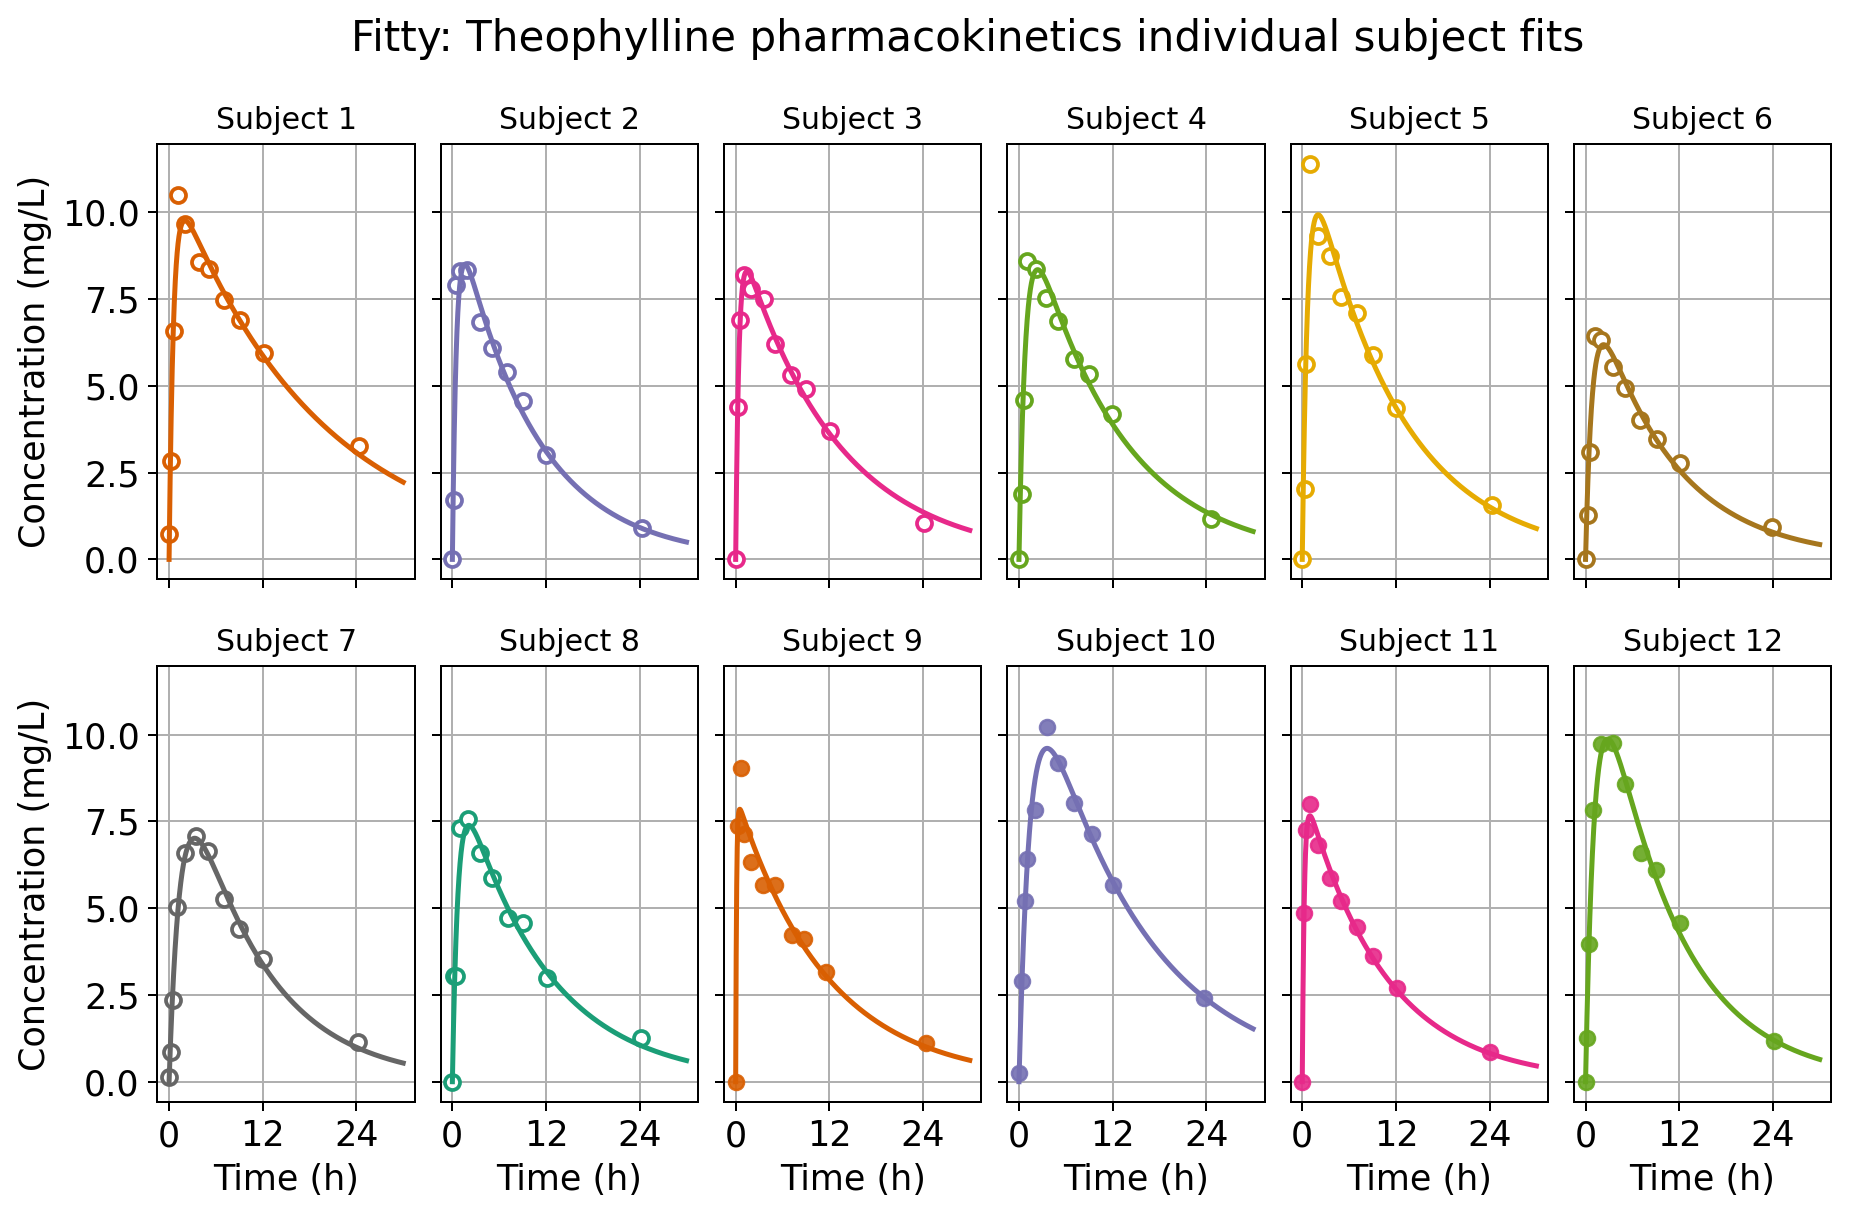

In [8]:
# Plot individual subject fits overlaid on data
fig, splots = subplots(figsize = (12, 7), ncols = 6, nrows = 2,
                       sharex = "all", sharey = "all")

spl = splots.ravel() 
for (jj, (s, df)) in enumerate(pairs(groupby(theoph, :Subject, sort = false)))
    ax = spl[jj-1]
    col = "C$jj"
    subj = s.Subject
    # Plot data
    if subj in ["1", "2", "3", "4", "5", "6", "7", "8"]
        ax.plot(df.Time, df.Conc, "o", color = col, mfc = "w", mew = 1.5, label = subj)
    else
        ax.plot(df.Time, df.Conc, "o", color = col, alpha = 0.9, label = subj)
    end
    # Overlay fit
    pred = preds[subj]
    ax.plot(times, pred, color = col, lw = 2)
    ax.set_title("Subject $subj", fontsize = 12)
    ax.grid()
    if jj > 6
        ax.set_xlabel("Time (h)")
        ax.set_xticks([0, 12, 24])
    end
    if jj in [1, 7]
        ax.set_ylabel("Concentration (mg/L)")
    end
end

suptitle("Fitty: Theophylline pharmacokinetics individual subject fits")
subplots_adjust(bottom = 0.12, wspace = 0.1);

## 5. Plot residuals

Plot residuals to visually assess the quality of fits

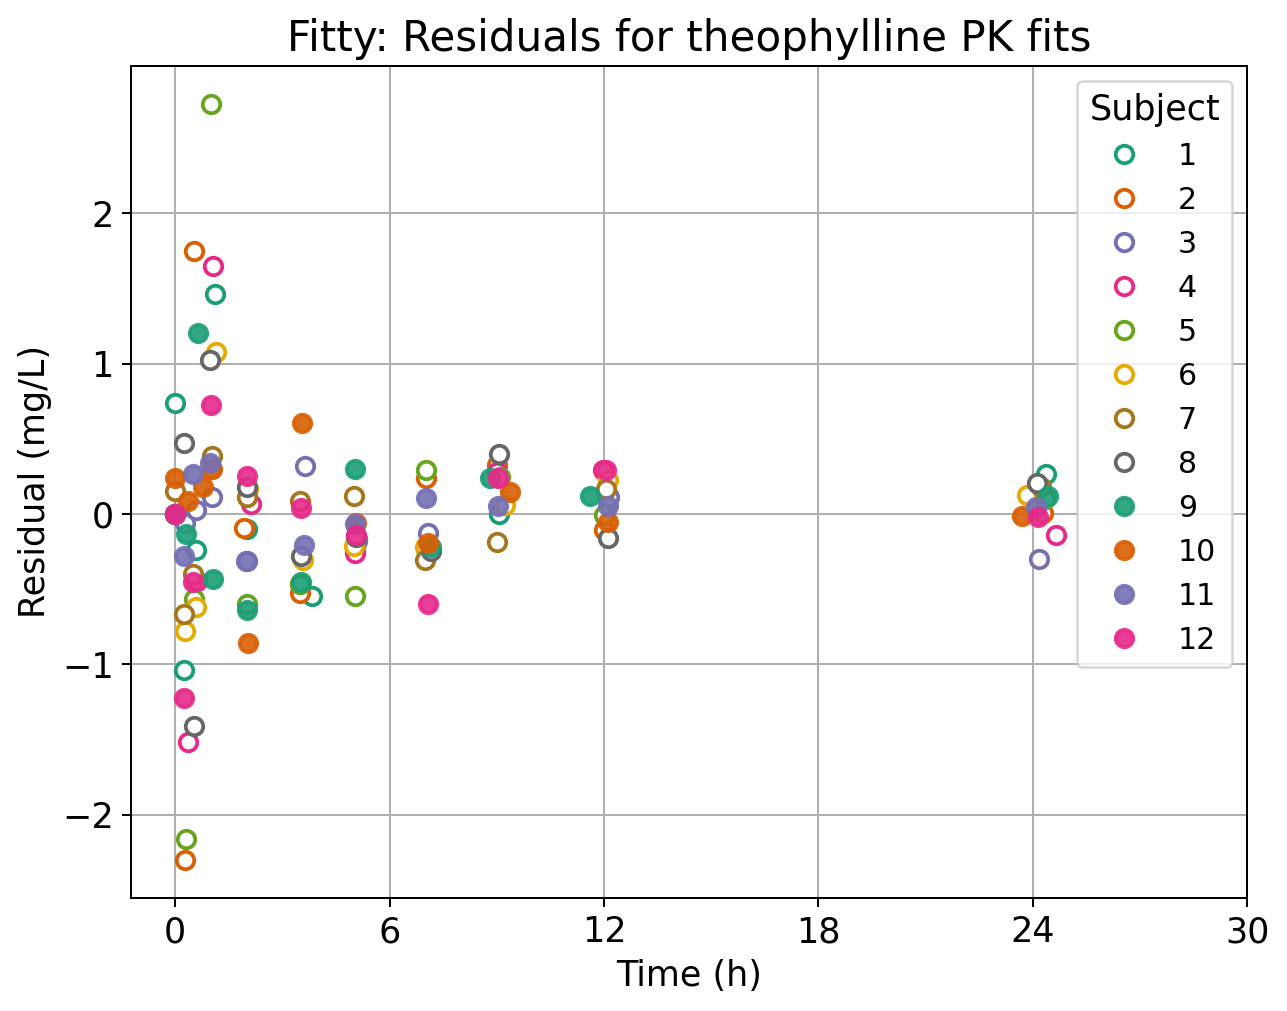

In [9]:
fig, ax = subplots(figsize = (8, 6))
for (s, df) in pairs(groupby(theoph, :Subject, sort = false))
    subj = s.Subject
    t = df.Time
    r = fits[subj].residuals
    if subj in ["1", "2", "3", "4", "5", "6", "7", "8"]
        ax.plot(t, r, "o", ms = 7, mfc = "w", 
                mew = 1.5, lw = 1, label = subj)
    else
        ax.plot(t, r, "o", ms = 7, alpha = 0.9,
                mew = 1.5, lw = 1, label = subj)
    end
end
ax.legend(title = "Subject", fontsize = 12)
ax.set_xticks([0, 6, 12, 18, 24, 30])
ax.set_xlabel("Time (h)")
ax.set_ylabel("Residual (mg/L)")
ax.grid()
ax.set_title("Fitty: Residuals for theophylline PK fits");

## 6. Covariate analysis 

Assess if estimated PK parameters are correlated with body weight